# Supervised Retrieval

In this notebook we use the supervised classification model for a supervised crosslingual information retrieval task.

In [3]:
import sys
import os
sys.path.append(os.path.dirname((os.path.abspath(''))))

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from src.models.predict_model import MAP_score

## I. Import Data

In this section we import the feature dataframe for the retrieval task.

In [4]:
feature_dataframe=pd.read_json("../data/processed/feature_dataframe.json")
feature_retrieval=pd.read_json("../data/processed/feature_retrieval_reduced.json")

In [5]:
feature_dataframe=feature_dataframe.sample(frac=1)
feature_dataframe

,source_id,target_id,number_punctuations_total_difference,number_punctuations_total_difference_relative,number_punctuations_total_difference_normalized,number_words_difference,number_words_difference_relative,number_words_difference_normalized,number_unique_words_difference,number_unique_words_difference_relative,...,pca_embeddding_tf_idf_diff_5,pca_embeddding_average_diff_6,pca_embeddding_tf_idf_diff_6,pca_embeddding_average_diff_7,pca_embeddding_tf_idf_diff_7,pca_embeddding_average_diff_8,pca_embeddding_tf_idf_diff_8,pca_embeddding_average_diff_9,pca_embeddding_tf_idf_diff_9,Translation
109,109,109,-1,-0.25,-0.009524,-5,-0.294118,0.009524,-4,-0.250000,...,-0.004874,-0.047148,-0.008058,-0.084391,-0.023995,0.010583,0.001481,-0.044518,-0.010591,1
22684,268,13222,3,3.00,0.000000,18,3.000000,0.000000,18,3.000000,...,-0.000299,0.013027,-0.001395,0.031509,0.015462,0.030560,0.014559,-0.068374,-0.027733,0
212257,19225,17786,1,0.50,0.035714,13,1.083333,-0.035714,14,1.400000,...,-0.048708,-0.071461,-0.028607,0.043429,0.007141,0.119771,0.028388,-0.099804,-0.028861,0
128119,10811,8960,4,4.00,-0.097222,11,1.375000,0.097222,11,1.375000,...,-0.026901,-0.047534,-0.018759,0.086064,0.023210,0.048726,0.012149,-0.054367,-0.012938,0
181804,16180,17021,3,0.00,-0.150000,10,1.428571,0.150000,10,1.428571,...,-0.047277,0.034917,0.010096,-0.031786,-0.018326,0.035693,0.008005,-0.027249,-0.007824,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202319,18231,7359,2,2.00,-0.130952,0,0.000000,0.130952,0,0.000000,...,-0.055980,0.061674,0.016336,-0.008921,-0.007011,0.085686,0.024694,-0.091589,-0.027445,0
7113,7113,7113,0,0.00,0.000000,0,0.000000,0.000000,0,0.000000,...,-0.004311,-0.183242,-0.110884,-0.089385,-0.054618,0.149621,0.075848,-0.097817,-0.055209,1
141879,12187,11226,-1,-0.50,0.015152,-4,-0.444444,-0.015152,-3,-0.375000,...,-0.005525,-0.063130,-0.002613,-0.031770,-0.011397,0.092851,0.040517,-0.175271,-0.062434,0
185057,16505,5751,4,0.00,-0.142857,13,1.181818,0.142857,13,1.181818,...,-0.030264,-0.091880,-0.027707,0.059644,0.011309,0.032890,0.005979,-0.039682,-0.009445,0


## II. Supervised Retrieval

### First iteration after dropping correlated features from analyes

In [6]:
import pickle 
file = open("../data/processed/correlated_features.pkl",'rb')
correlated_features = pickle.load(file)
file.close()
correlated_features

{'characters_avg_difference_relative',
 'cosine_similarity_tf_idf',
 'euclidean_distance_tf_idf',
 'jaccard_translation_target',
 'number_#_difference_normalized',
 'number_#_difference_relative',
 'number_$_difference_normalized',
 'number_$_difference_relative',
 'number_%_difference_normalized',
 'number_&_difference_normalized',
 "number_'_difference_normalized",
 "number_'_difference_relative",
 'number_)_difference',
 'number_)_difference_normalized',
 'number_)_difference_relative',
 'number_+_difference_normalized',
 'number_+_difference_relative',
 'number_,_difference',
 'number_,_difference_relative',
 'number_-_difference_normalized',
 'number_._difference_relative',
 'number_/_difference_normalized',
 'number_NOUN_difference',
 'number_[_difference_normalized',
 'number_[_difference_relative',
 'number_]_difference',
 'number_]_difference_normalized',
 'number_]_difference_relative',
 'number_characters_difference',
 'number_characters_difference_relative',
 'number_stopwo

In [7]:
feature_dataframe=feature_dataframe.drop(columns=correlated_features)
feature_dataframe

,source_id,target_id,number_punctuations_total_difference,number_punctuations_total_difference_relative,number_punctuations_total_difference_normalized,number_words_difference,number_words_difference_relative,number_!_difference,number_!_difference_relative,number_!_difference_normalized,...,pca_embeddding_average_diff_2,pca_embeddding_tf_idf_diff_2,pca_embeddding_average_diff_3,pca_embeddding_average_diff_4,pca_embeddding_average_diff_5,pca_embeddding_average_diff_6,pca_embeddding_average_diff_7,pca_embeddding_average_diff_8,pca_embeddding_average_diff_9,Translation
109,109,109,-1,-0.25,-0.009524,-5,-0.294118,1,0,-0.066667,...,0.000003,-0.001361,-0.003251,-0.058206,-0.042816,-0.047148,-0.084391,0.010583,-0.044518,1
22684,268,13222,3,3.00,0.000000,18,3.000000,0,0,0.000000,...,-0.059663,-0.005186,-0.023072,-0.005830,0.000950,0.013027,0.031509,0.030560,-0.068374,0
212257,19225,17786,1,0.50,0.035714,13,1.083333,0,0,0.000000,...,0.009355,0.006870,0.021219,-0.053048,-0.169190,-0.071461,0.043429,0.119771,-0.099804,0
128119,10811,8960,4,4.00,-0.097222,11,1.375000,0,0,0.000000,...,-0.028330,-0.010495,-0.026490,-0.086742,-0.097948,-0.047534,0.086064,0.048726,-0.054367,0
181804,16180,17021,3,0.00,-0.150000,10,1.428571,0,0,0.000000,...,-0.087906,-0.012733,0.107612,0.004078,-0.100966,0.034917,-0.031786,0.035693,-0.027249,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202319,18231,7359,2,2.00,-0.130952,0,0.000000,0,0,0.000000,...,0.040491,0.011073,0.013887,-0.014963,-0.177531,0.061674,-0.008921,0.085686,-0.091589,0
7113,7113,7113,0,0.00,0.000000,0,0.000000,0,0,0.000000,...,-0.034515,-0.004604,0.347093,0.121631,0.045028,-0.183242,-0.089385,0.149621,-0.097817,1
141879,12187,11226,-1,-0.50,0.015152,-4,-0.444444,0,0,0.000000,...,0.019947,0.000543,0.058875,0.026531,-0.057264,-0.063130,-0.031770,0.092851,-0.175271,0
185057,16505,5751,4,0.00,-0.142857,13,1.181818,0,0,0.000000,...,-0.102474,-0.024596,0.005421,-0.048078,-0.109183,-0.091880,0.059644,0.032890,-0.039682,0


In [8]:
feature_dataframe=feature_dataframe.drop(columns=['word_mover_distance'])

In [9]:
feature_dataframe.columns.difference(feature_retrieval.columns)

Index([], dtype='object')

#### drop the target label and the indexes for training and testing

In [11]:
target_train=feature_dataframe['Translation'].astype(float)
data_train=feature_dataframe.drop(columns=['Translation','source_id','target_id'])
target_test=feature_retrieval['Translation'].astype(float)
data_test=feature_retrieval.drop(columns=['Translation','source_id','target_id'])

In [12]:
keep_columns = list(range(106, 110))

In [13]:
data_train = data_train.iloc[:, keep_columns]
data_test = data_test.iloc[:, keep_columns]

In [14]:
data_train.columns

Index(['cosine_similarity_average', 'euclidean_distance_average',
       'jaccard_translation_source', 'jaccard_numbers_source'],
      dtype='object')

In [15]:
#scale data into [0,1]
scaler = preprocessing.StandardScaler()
#scaler = preprocessing.MinMaxScaler()
data_train[data_train.columns] = scaler.fit_transform(data_train[data_train.columns])
data_test[data_test.columns] = scaler.transform(data_test[data_test.columns])

In [16]:
import numpy as np
from sklearn.utils import shuffle


def downsample(imbalanced_data):
    y = imbalanced_data["Translation"].astype(int)
    y = np.where((y == 0), 0, 1)
    
    # Indicies of each class' observations
    i_class0 = np.where(y == 0)[0]
    i_class1 = np.where(y == 1)[0]

    # Number of observations in each class
    n_class0 = len(i_class0)
    n_class1 = len(i_class1)
    print("Class 0 size: {}".format(n_class0))
    print("Class 1 size: {}".format(n_class1))

    # For every observation of class 1, randomly sample from class 0 without replacement
    i_class0_downsampled = np.random.choice(i_class0, size=n_class1, replace=False)
    print("After Downsampling:")
    print("Class 0 size: {}".format(len(i_class0_downsampled)))
    print("Class 1 size: {}".format(n_class1))
    index_balanced = i_class0_downsampled.tolist() + i_class1.tolist()
    index_balanced = shuffle(index_balanced, random_state=42)
    return imbalanced_data.iloc[index_balanced, :]

#data_train["Translation"] = target_train
#data_train = downsample(data_train)
#target_train=data_train['Translation']
#data_train=data_train.drop(columns=['Translation'])

# Naive Bayes

In [17]:
nb = GaussianNB().fit(data_train, target_train)
prediction = nb.predict_proba(data_test)
print("The MAP score on test set: {:.4f}".format(MAP_score(feature_retrieval['source_id'],target_test,prediction)))
# acc = accuracy_score(target_test,prediction) 
# f1= f1_score(target_test,prediction) 
# pr= precision_score(target_test,prediction) 
# re= recall_score(target_test,prediction)
# ll=log_loss(target_test,prediction)
# print("The Accuracy on test set: {:.4f}".format(acc))
# print("The F1-Score on test set: {:.4f}".format(f1))
# print("The Precision-Score on test set: {:.4f}".format(pr))
# print("The Recall-Score on test set: {:.4f}".format(re))
# print("The Los_loss on test set: {:.4f}".format(ll))

The MAP score on test set: 0.6800


In [18]:
prediction

array([[3.65384284e-12, 1.00000000e+00],
       [9.99868929e-01, 1.31071357e-04],
       [9.99778234e-01, 2.21766386e-04],
       ...,
       [9.99797580e-01, 2.02419995e-04],
       [9.99729662e-01, 2.70337587e-04],
       [9.92018231e-01, 7.98176869e-03]])

## prediction ist schwachsinn, da nur 0 mit confidence 1 predicted wird

# MLP Classifier

In [19]:
mlp = MLPClassifier().fit(data_train, target_train)
prediction = mlp.predict_proba(data_test)
print("The MAP score on test set: {:.4f}".format(MAP_score(feature_retrieval['source_id'],target_test,prediction)))
# acc = accuracy_score(target_test,prediction) 
# f1= f1_score(target_test,prediction) 
# pr= precision_score(target_test,prediction) 
# re= recall_score(target_test,prediction) 
# ll=log_loss(target_test,prediction)
# print("The Accuracy on test set: {:.4f}".format(acc))
# print("The F1-Score on test set: {:.4f}".format(f1))
# print("The Precision-Score on test set: {:.4f}".format(pr))
# print("The Recall-Score on test set: {:.4f}".format(re))
# print("The Los_loss on test set: {:.4f}".format(ll))

The MAP score on test set: 0.7500


# Logistic Regression

In [20]:
lr = LogisticRegression(max_iter=1000000).fit(data_train.to_numpy(), target_train.to_numpy())
prediction = lr.predict_proba(data_test.to_numpy())
print("The MAP score on test set: {:.4f}".format(MAP_score(feature_retrieval['source_id'],target_test,prediction)))
# acc = accuracy_score(target_test,prediction) 
# f1= f1_score(target_test,prediction) 
# pr= precision_score(target_test,prediction) 
# re= recall_score(target_test,prediction) 
# ll=log_loss(target_test,prediction)
# print("The Accuracy on test set: {:.4f}".format(acc))
# print("The F1-Score on test set: {:.4f}".format(f1))
# print("The Precision-Score on test set: {:.4f}".format(pr))
# print("The Recall-Score on test set: {:.4f}".format(re))
# print("The Los_loss on test set: {:.4f}".format(ll))

The MAP score on test set: 0.6759


Feature: 0, Score: -0.28636
Feature: 1, Score: 0.13939
Feature: 2, Score: 3.51967
Feature: 3, Score: 0.60266


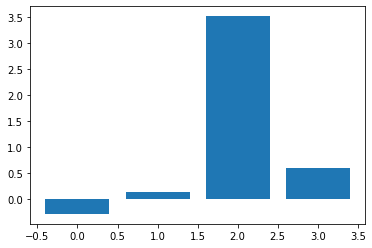

In [21]:
from matplotlib import pyplot
# get importance
importance = lr.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# XGBoost

In [22]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(data_train.to_numpy(), target_train.to_numpy())

/Users/I534344/opt/anaconda3/envs/ml/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
prediction = model.predict_proba(data_test).tolist()
print("The MAP score on test set: {:.4f}".format(MAP_score(feature_retrieval['source_id'],target_test,prediction)))




The MAP score on test set: 0.6635


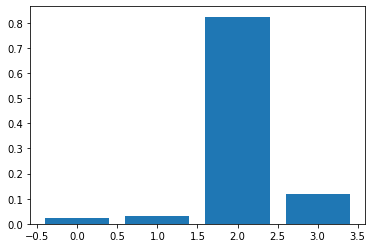

In [24]:
from matplotlib import pyplot

# feature importance

pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

# Try Autoencoder dimenstionality reduction

In [ ]:
from keras import layers, Input, Model

target_train=feature_dataframe['Translation'].astype(float)
data_train=feature_dataframe.drop(columns=['Translation','source_id','target_id'])
target_test=feature_retrieval['Translation'].astype(float)
data_test=feature_retrieval.drop(columns=['Translation','source_id','target_id'])

In [ ]:
scaler = preprocessing.StandardScaler()
#scaler = preprocessing.MinMaxScaler()
data_train[data_train.columns] = scaler.fit_transform(data_train[data_train.columns])
data_test[data_test.columns] = scaler.transform(data_test[data_test.columns])

In [ ]:
input_shape = data_train.shape[1]
encoding_dim = 30
print("Input dim: {}".format(data_train.shape))

input_df = Input(shape=(input_shape,))
encoded = layers.Dense(encoding_dim, activation="linear", kernel_initializer=keras.initializers.Ones())(input_df)
decoded = layers.Dense(input_shape, activation="linear", kernel_initializer=keras.initializers.Ones())(encoded)

# encoder
autoencoder = Model(input_df, decoded)

# intermediate result
encoder = Model(input_df, encoded)
opt=keras.optimizers.Adam(learning_rate=0.01)
autoencoder.compile(optimizer=opt, loss='mean_squared_error')

autoencoder.fit(data_train.iloc[:200000, :], data_train.iloc[:200000, :],
                epochs=150,
                batch_size=256,
                shuffle=True,
                validation_data=(data_train.iloc[200000:, :], data_train.iloc[200000:, :]))

In [ ]:
encode_data_train = encoder.predict(data_train)

In [ ]:
encode_data_test = encoder.predict(data_test)

In [ ]:
lr = LogisticRegression(max_iter=1000000).fit(encode_data_train, target_train.to_numpy())
prediction = lr.predict_proba(encode_data_test)
print("The MAP score on test set: {:.4f}".format(MAP_score(feature_retrieval['source_id'],target_test,prediction)))
# acc = accuracy_score(target_test,prediction) 
# f1= f1_score(target_test,prediction) 
# pr= precision_score(target_test,prediction) 
# re= recall_score(target_test,prediction) 
# ll=log_loss(target_test,prediction)
# print("The Accuracy on test set: {:.4f}".format(acc))
# print("The F1-Score on test set: {:.4f}".format(f1))
# print("The Precision-Score on test set: {:.4f}".format(pr))
# print("The Recall-Score on test set: {:.4f}".format(re))
# print("The Los_loss on test set: {:.4f}".format(ll))